In [1]:

%matplotlib notebook

import numpy as np
from scipy import ndimage
import scipy
import matplotlib.pyplot as plt
import torch
import skimage
import cv2

from multiPoseExtraction import MultiPoseExtraction
from PoseExtraction import PoseNormalization
from deepHOG import DeepHOG
from deepHogNormalization import DeepHogNormalization
import utils
import datasets as ds
from torch.autograd import Variable
from torchvision import datasets, transforms

import time
import glob

from smallnorb import SmallNORBExample, SmallNORBDataset

def plot_arrow_img(ax, means, orientations, img_shape, arrow_scale=2, color=(1, 0, 0), alpha=0.8):
    mean_x = means[0].cpu().data.numpy()
    mean_y = means[1].cpu().data.numpy()

    rot = orientations.cpu().data.numpy()
    arrow_start = (mean_x, img_shape[1] - mean_y)
    arrow_end = (rot[0]*arrow_scale, -1*rot[1]*arrow_scale)

    #         ax[index % row_length].arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
    #                     head_width=0.5, head_length=1, fc='red', ec='r', linewidth=4, alpha=1)

    ax.arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
                head_width=np.sqrt(arrow_scale/4), head_length=np.sqrt(arrow_scale/4), fc='red', ec=color, linewidth=4, alpha=alpha)


In [2]:
dataset = SmallNORBDataset('./data/small_norb_root')
train, test, details = ds.smallNORBsingle()

Loading info...: 100%|██████████| 24300/24300 [00:00<00:00, 421236.69it/s]


Loaded From File

torch.Size([48600, 1, 96, 96])
torch.Size([48600, 1])
torch.Size([10000, 1, 96, 96])
torch.Size([10000, 1])


In [4]:
from models.smallNorb import PINN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pinn = PINN().to(device)
criterion_pinn = torch.nn.CrossEntropyLoss()
optimizer_pinn = torch.optim.Adam(pinn.parameters(), lr=0.005)

batch_num = 55
epoch_num = 10
pinn, pinn_loss, pinn_acc, pinn_loss_validation = utils.train_net(pinn, train, 
              test, criterion_pinn, optimizer_pinn, batch_num, epoch_num, validation_split=0.1)

TOTAL TRAIN 1760
TOTAL VALIDATION 4860
TOTAL TEST 10000
STOPPING EPOCH
Loss: 0.049419525062496014, Acc: 0.2755681818181818, Validation Loss: 0.04523955647346905
STOPPING EPOCH
Loss: 0.04255408306013454, Acc: 0.4318181818181818, Validation Loss: 0.04790768083721522
STOPPING EPOCH
Loss: 0.03561296022751115, Acc: 0.5261363636363636, Validation Loss: 0.033104916990048604
STOPPING EPOCH
Loss: 0.03102842877534303, Acc: 0.5875, Validation Loss: 0.04718444428326171
STOPPING EPOCH
Loss: 0.0284963133321567, Acc: 0.6147727272727272, Validation Loss: 0.02292685130986657
STOPPING EPOCH
Loss: 0.02865321212871508, Acc: 0.6113636363636363, Validation Loss: 0.19712254853896152
STOPPING EPOCH
Loss: 0.0259899205443534, Acc: 0.6517045454545455, Validation Loss: 0.018244912361902465
STOPPING EPOCH
Loss: 0.023756237463517623, Acc: 0.6801136363636363, Validation Loss: 0.043102931130079576
STOPPING EPOCH
Loss: 0.023817195065996864, Acc: 0.6795454545454546, Validation Loss: 0.03632370811185719
STOPPING EPOCH
L

Current Batch 14
torch.Size([32, 1, 2, 1]) torch.Size([32, 1, 2])


<IPython.core.display.Javascript object>


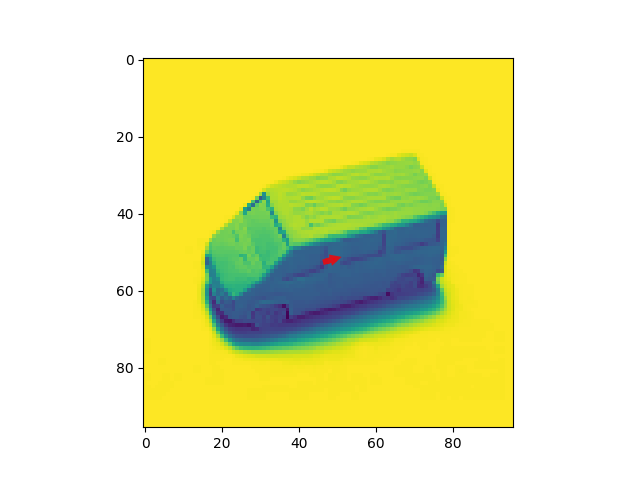

In [5]:
def get_pose(x):
    intermediate = pinn.pose_normalizer[0](x)
    output, blocks, mu_global, U_global, theta = pinn.pose_normalizer[1].pose_normalizer(intermediate)
    return mu_global, U_global

specific_batch = np.random.randint(50)
print("Current Batch", specific_batch)

for i, (imgs, labels) in enumerate(train):
    if i == specific_batch:
        break

example_index = 0
mu, U = get_pose(imgs.cuda())
mu = mu.data.cpu()
U = U.data.cpu()
current_img = imgs[example_index, 0, :, :]
current_mean = mu[example_index, 0, :, 0]
current_orientation = U[example_index, 0, :]
img_shape = current_img.shape

print(mu.shape, U.shape)
fig, ax = plt.subplots()
ax.imshow(current_img)

plot_arrow_img(ax, current_mean, current_orientation, img_shape, arrow_scale=2, color=(1, 0, 0), alpha=0.8)

In [6]:
pose = []
img_data = []
ignore_list = [(0, 7),
               (1, 7), (1, 9), 
               (2, 7), (2, 9), 
               (3, 7), 
               (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9)]

for index in range(len(dataset.data['train'])):
    norb_instance = dataset.data['train'][index]
    instance = norb_instance.instance
    category = norb_instance.category
    
    if (category, instance) in ignore_list:
        continue
    
    current_img = torch.from_numpy(norb_instance.image_lt).unsqueeze(0).float() 
    img_data.append(current_img)
    
    angle = -1*np.radians(norb_instance.azimuth * 10 % 180)
    if abs(angle) > (np.pi / 2):
        angle = angle % (np.pi / 2)
        
    x_diff, y_diff = (np.cos(angle), np.sin(angle))
    pose.append([x_diff, y_diff])
    
pose = np.asarray(pose)
pose = torch.from_numpy(pose)
img_data = torch.stack(img_data, dim=0)

print(pose.shape)
print(img_data.shape)

torch.Size([13608, 2])
torch.Size([13608, 1, 96, 96])


0


<IPython.core.display.Javascript object>


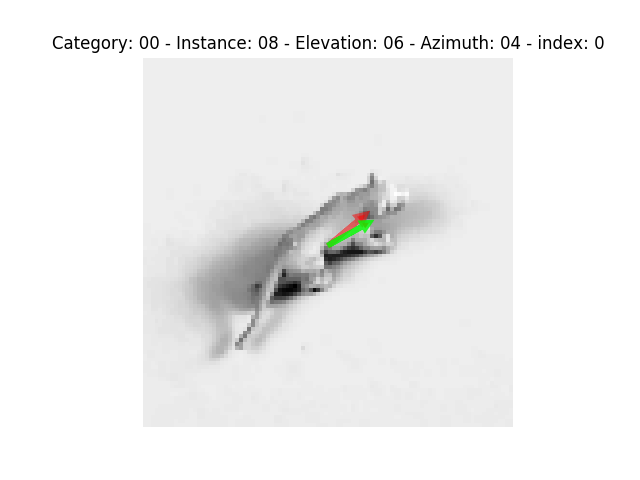

-40.0
1


<IPython.core.display.Javascript object>


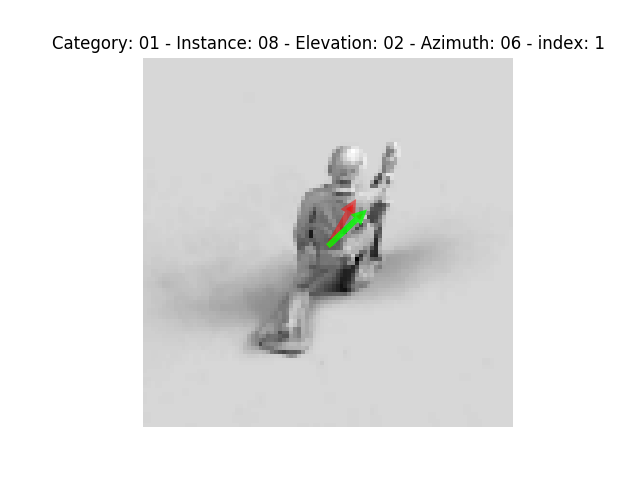

-59.99999999999999
2


<IPython.core.display.Javascript object>


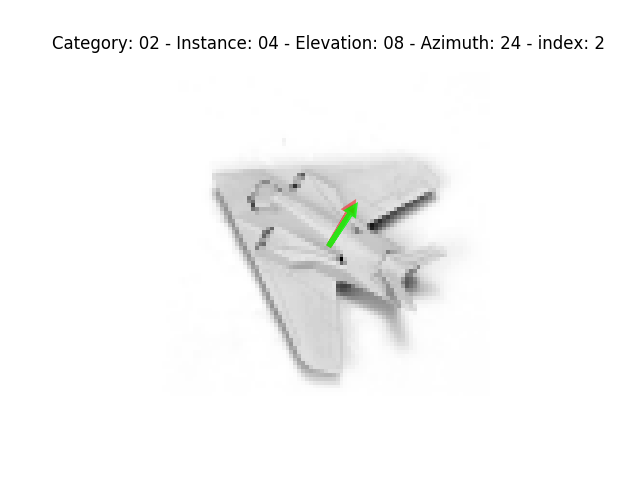

-59.99999999999999
5


<IPython.core.display.Javascript object>


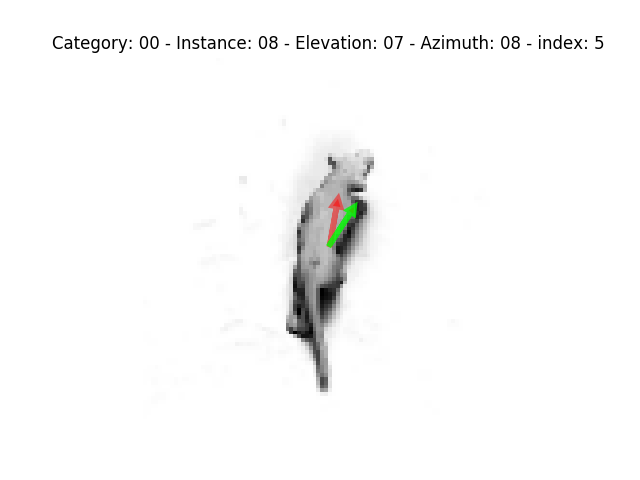

-80.0
10


<IPython.core.display.Javascript object>


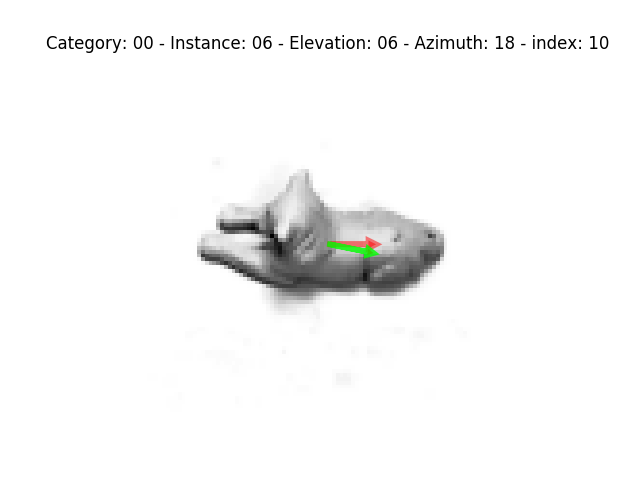

-0.0
11


<IPython.core.display.Javascript object>


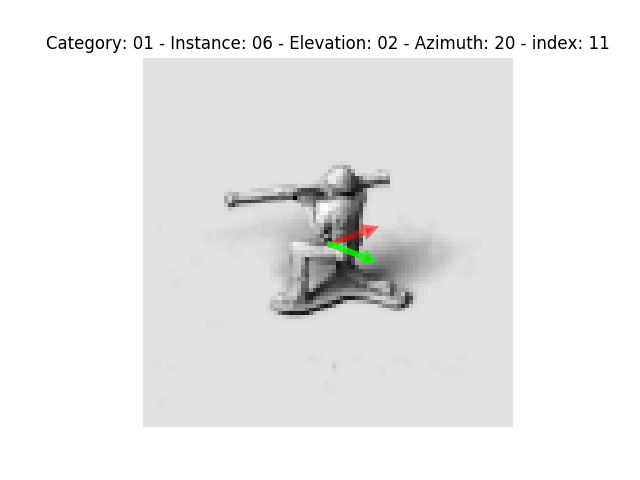

-20.0
12


<IPython.core.display.Javascript object>


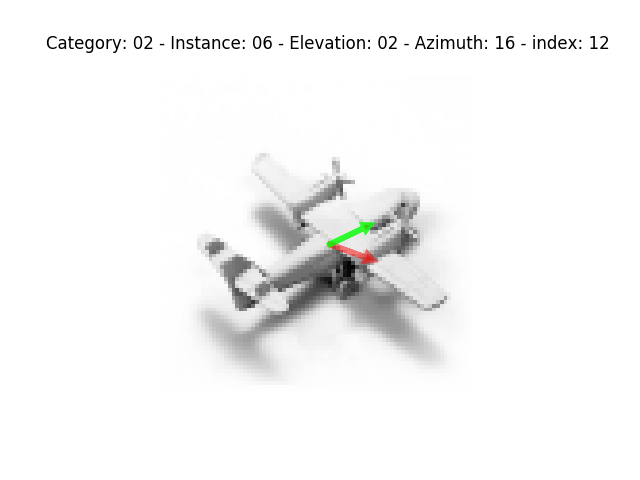

20.000000000000004
13


<IPython.core.display.Javascript object>


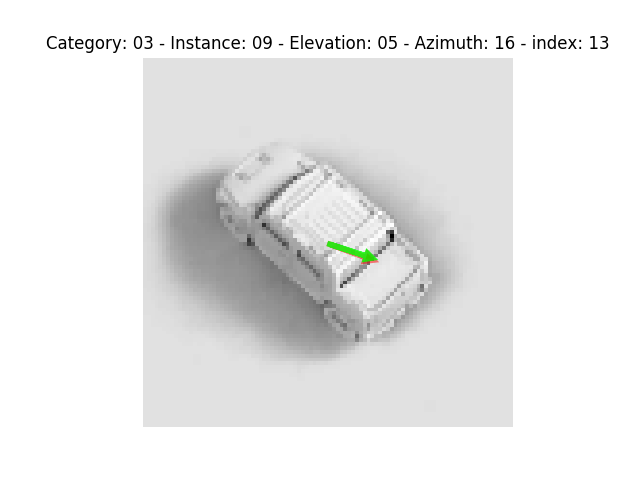

20.000000000000004
15


<IPython.core.display.Javascript object>


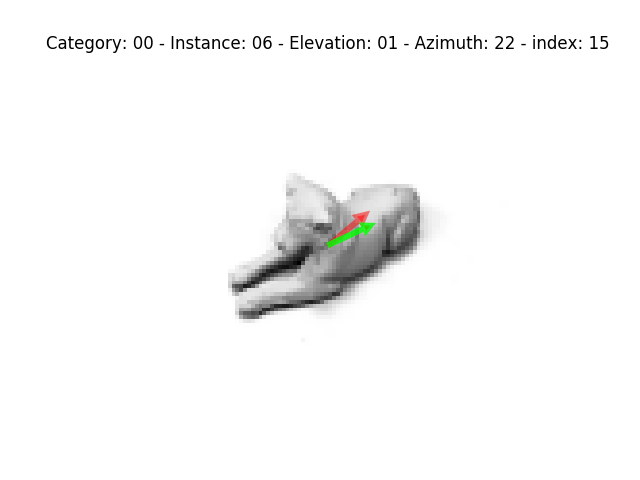

-40.0
16


<IPython.core.display.Javascript object>


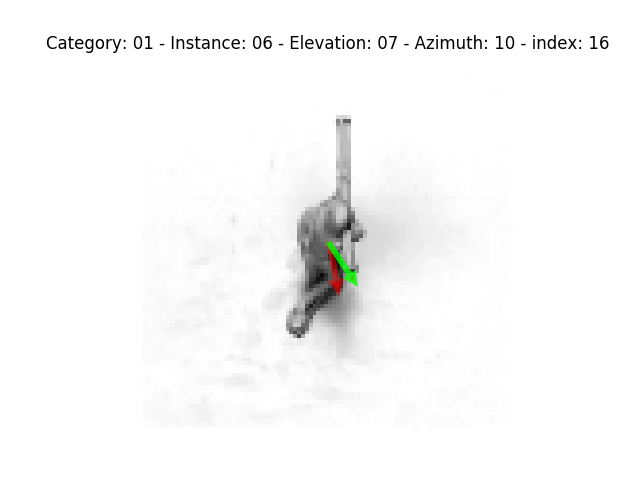

80.0
17


<IPython.core.display.Javascript object>


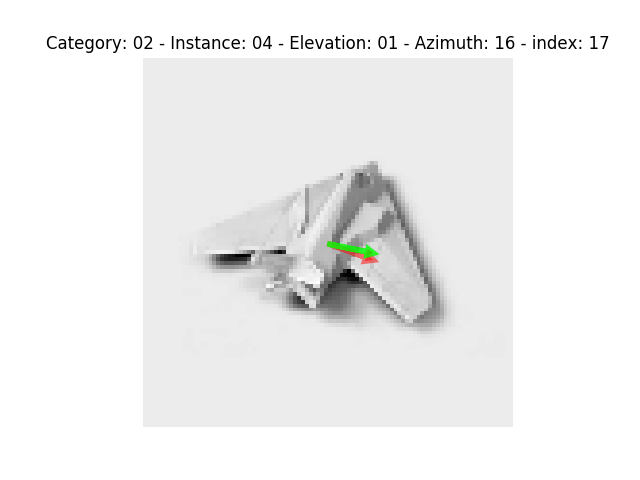

20.000000000000004
18


<IPython.core.display.Javascript object>


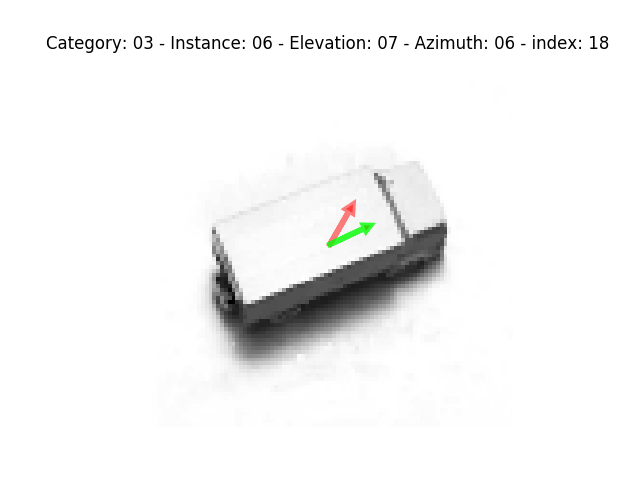

-59.99999999999999
20


<IPython.core.display.Javascript object>


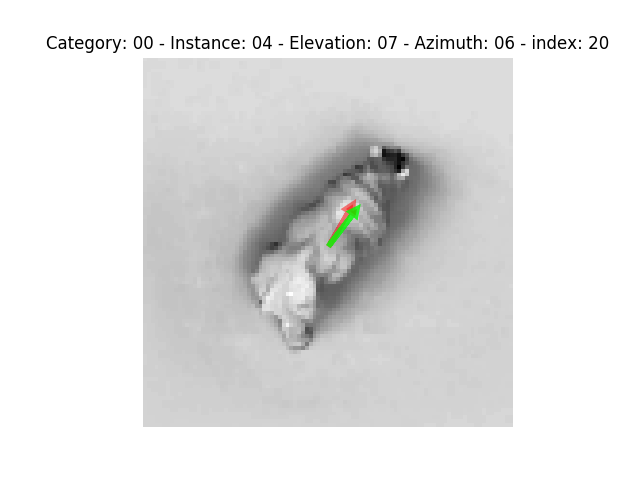

-59.99999999999999
22


<IPython.core.display.Javascript object>


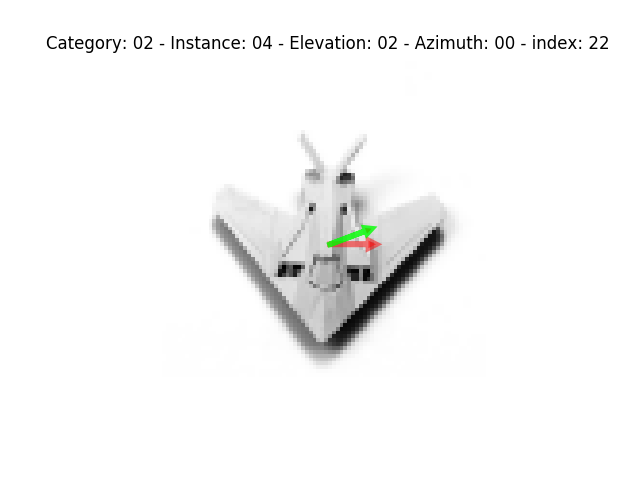

-0.0
23


<IPython.core.display.Javascript object>


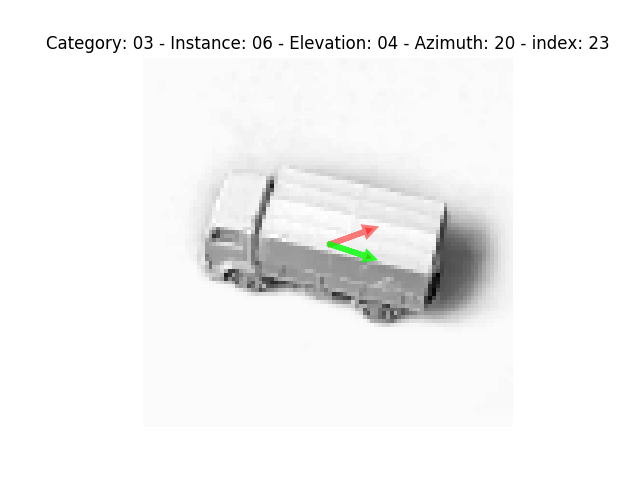

-20.0
25


<IPython.core.display.Javascript object>


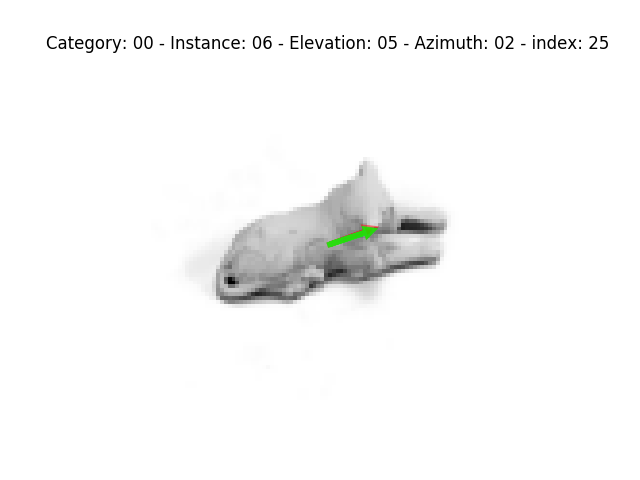

-20.0
26


<IPython.core.display.Javascript object>


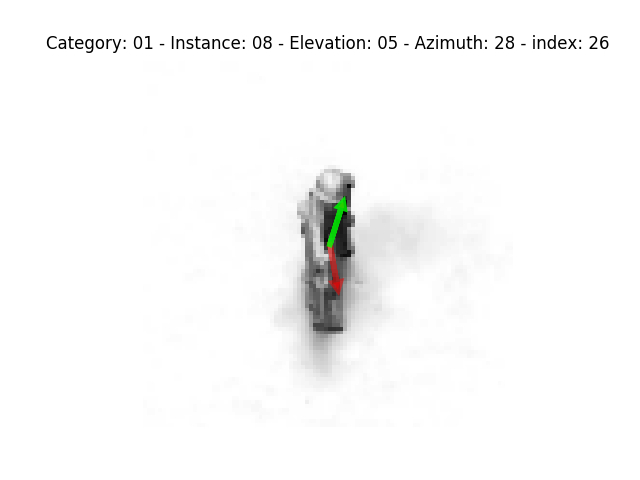

80.0
28


<IPython.core.display.Javascript object>


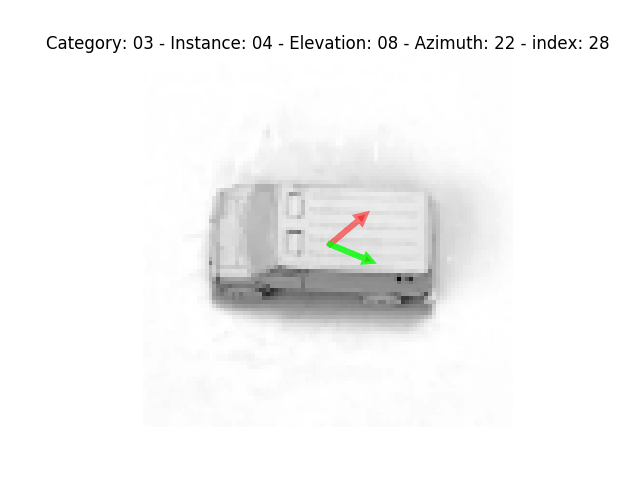

-40.0
30


<IPython.core.display.Javascript object>


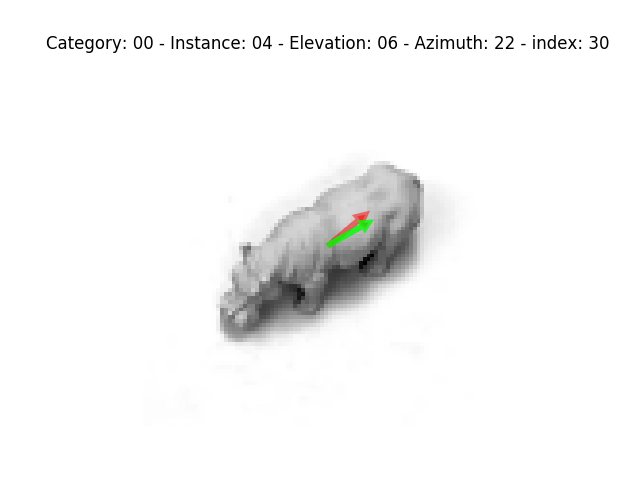

-40.0
31


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


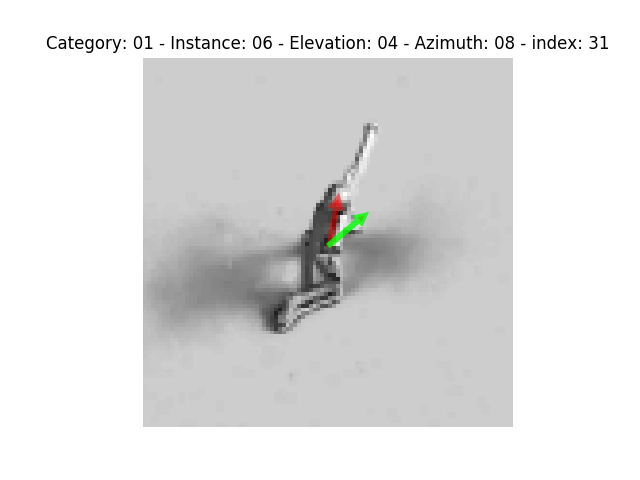

-80.0
32


<IPython.core.display.Javascript object>


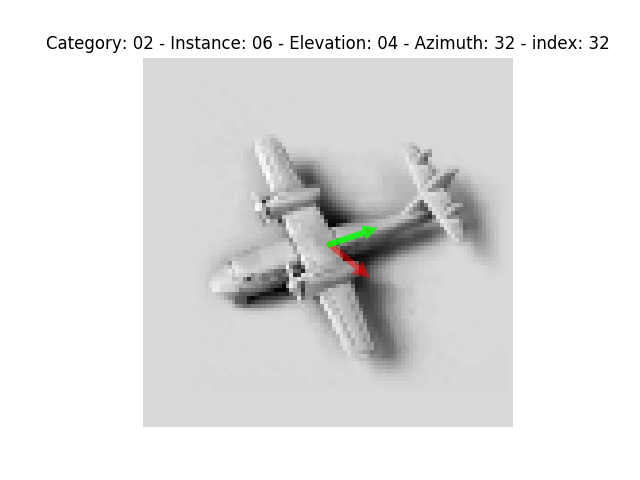

40.00000000000001


In [7]:
count = 0
num_examples = 30
index = 0
while count < num_examples and count <= 20:
    norb_instance = dataset.data['train'][index]
    category, instance = norb_instance.category, norb_instance.instance
    if (category, instance) in ignore_list:
        index += 1
        continue
#     if norb_instance.category != 0:
#         index += 1
#         continue
    
    print(index)
    
    current_img = torch.from_numpy(norb_instance.image_lt).unsqueeze(0).unsqueeze(1).float()    
            
    angle = -1*np.radians(norb_instance.azimuth * 10 % 180)
    if abs(angle) > (np.pi / 2):
        angle = angle % (np.pi / 2)
    arrow_scale = 4
    x_diff, y_diff = (np.cos(angle), np.sin(angle))
    
    fig, ax = plt.subplots()    
    ax.imshow(norb_instance.image_lt, cmap='gray')
    ax.axis('off')
    ax.set_title(
     'Category: {:02d} - Instance: {:02d} - Elevation: {:02d} - Azimuth: {:02d} - index: {}'.format(
        norb_instance.category, norb_instance.instance, norb_instance.elevation, norb_instance.azimuth, index))
    
    print(angle * (180 / np.pi))
    mu, U = get_pose(current_img.cuda())
    mu = mu.data.cpu()
    U = U.data.cpu()
    
    current_mean = mu[0, 0, :, 0]
    current_orientation = U[0, 0, :]
    img_shape = current_img.shape
    arrow_scale = 10
    ax.arrow(48, 48, x_diff * arrow_scale, y_diff * arrow_scale,
                head_width=2, head_length=2, fc='red', ec='red', linewidth=4, alpha=0.5)
    
    plot_arrow_img(ax, torch.Tensor([48, 48]), current_orientation, 
                   (96, 96), arrow_scale=10, color=(0, 1, 0), alpha=0.8)
    
    count += 1
    index += 1

# Evaluate MSE

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


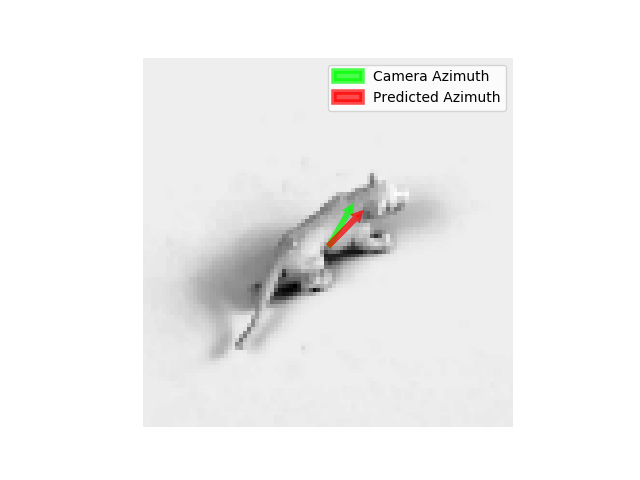

<IPython.core.display.Javascript object>


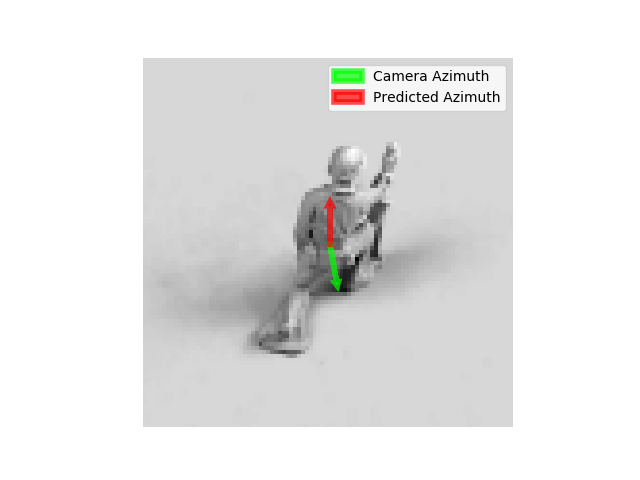

<IPython.core.display.Javascript object>


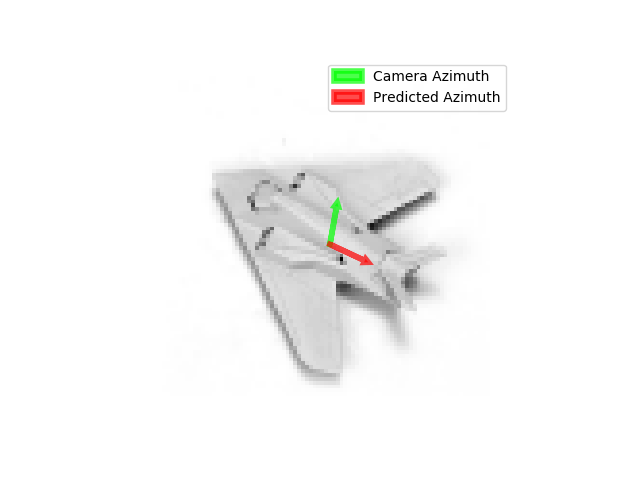

<IPython.core.display.Javascript object>


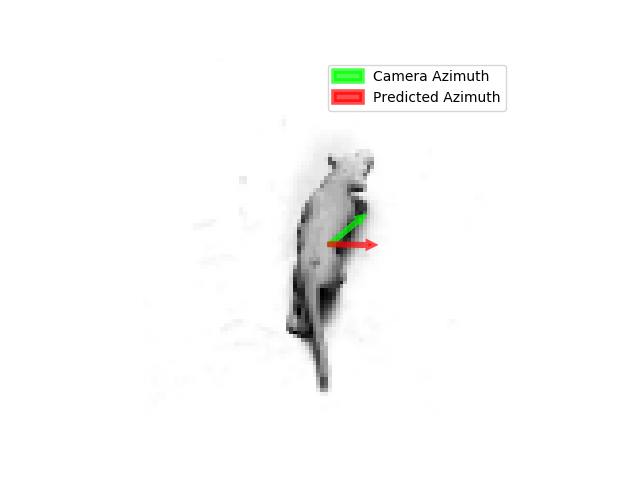

<IPython.core.display.Javascript object>


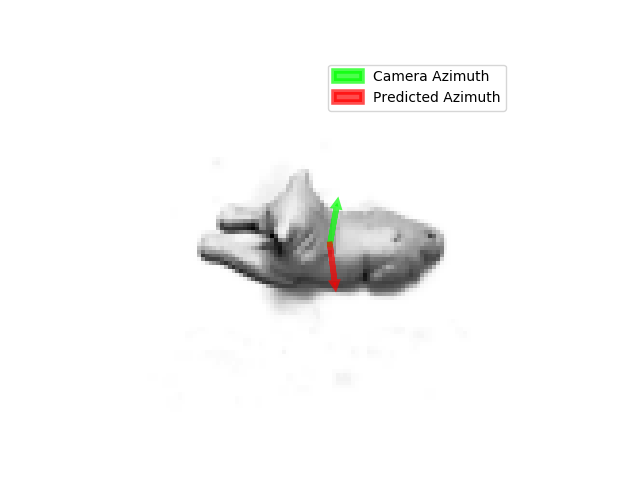

<IPython.core.display.Javascript object>


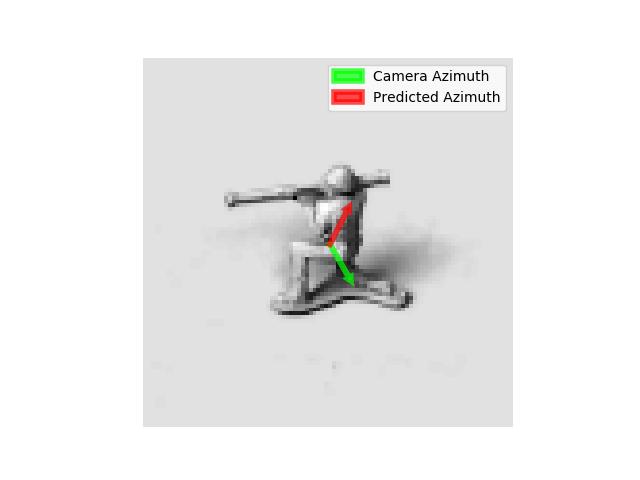

<IPython.core.display.Javascript object>


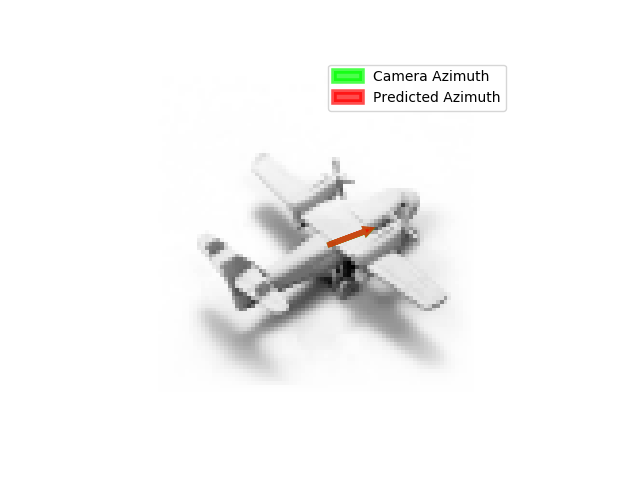

<IPython.core.display.Javascript object>


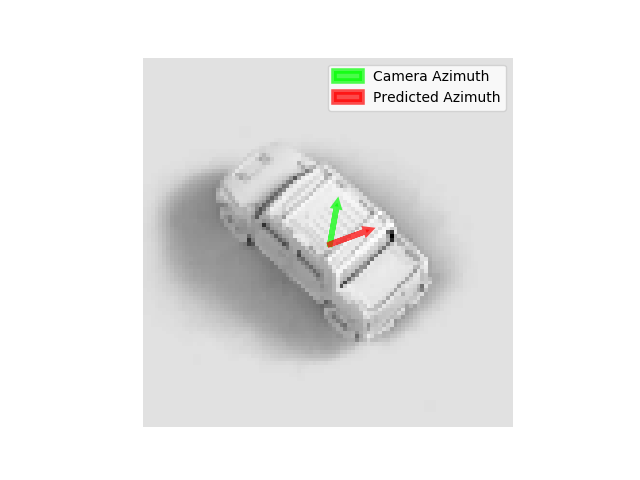

<IPython.core.display.Javascript object>


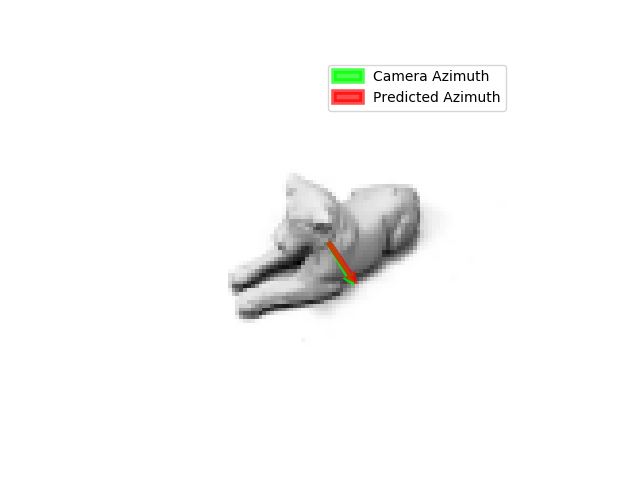

<IPython.core.display.Javascript object>


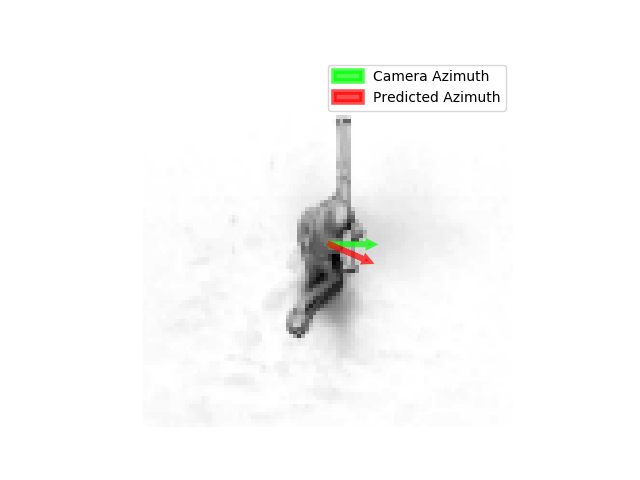

<IPython.core.display.Javascript object>


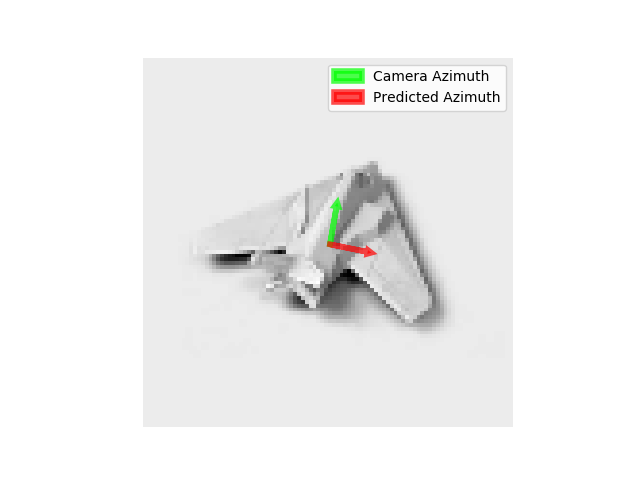

<IPython.core.display.Javascript object>


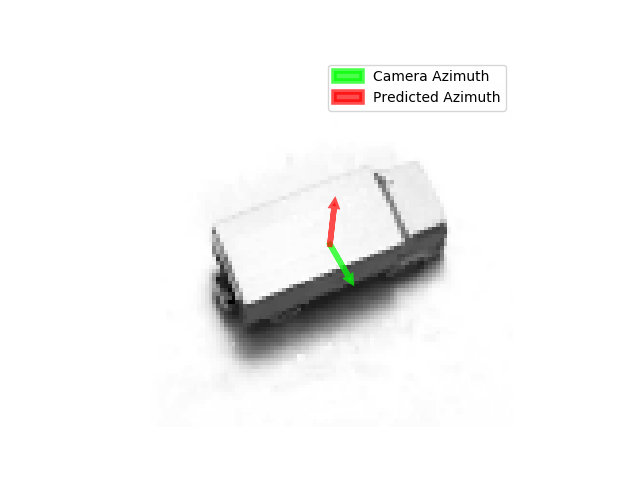

<IPython.core.display.Javascript object>


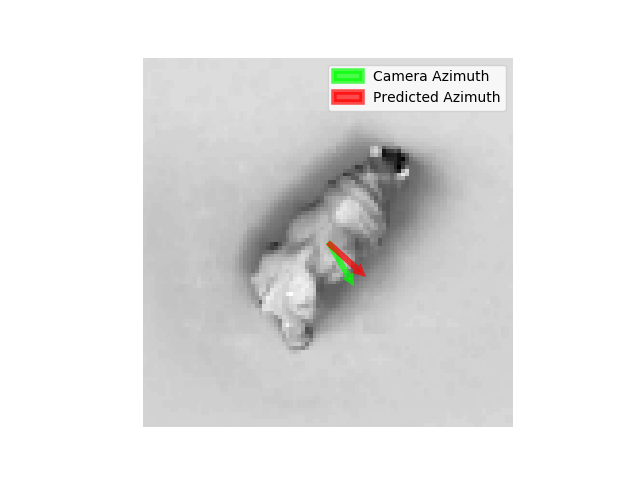

<IPython.core.display.Javascript object>


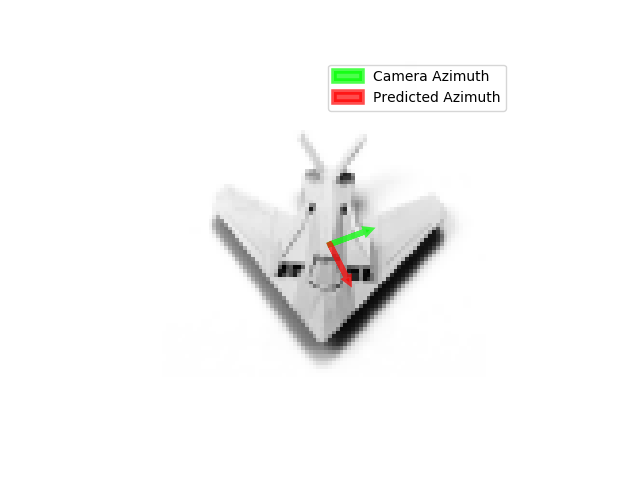

<IPython.core.display.Javascript object>


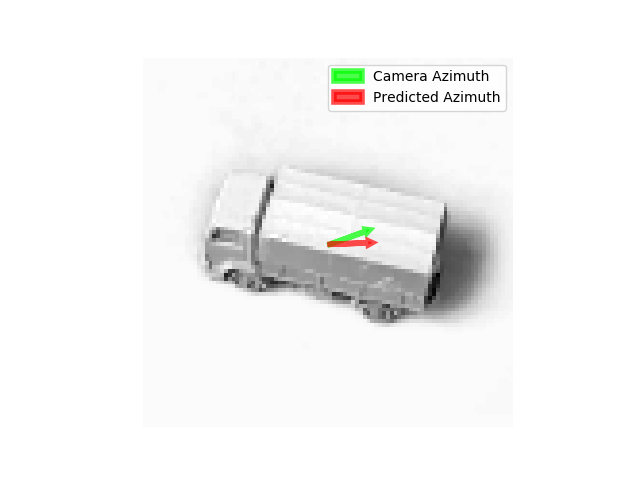

<IPython.core.display.Javascript object>


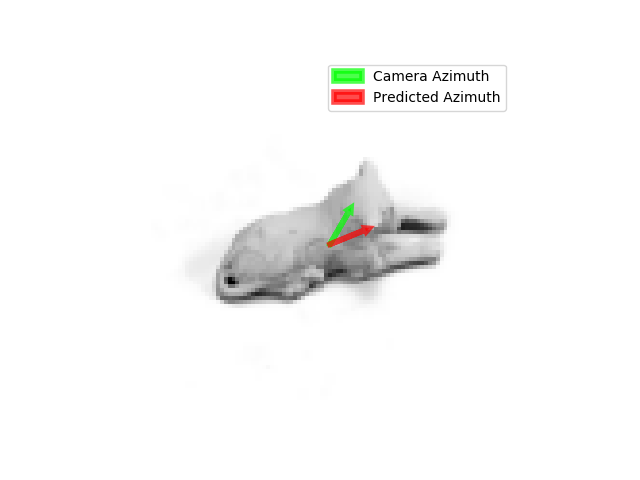

<IPython.core.display.Javascript object>


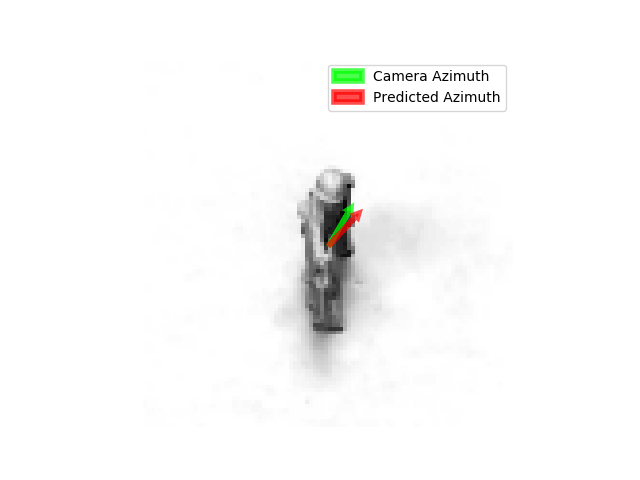

<IPython.core.display.Javascript object>


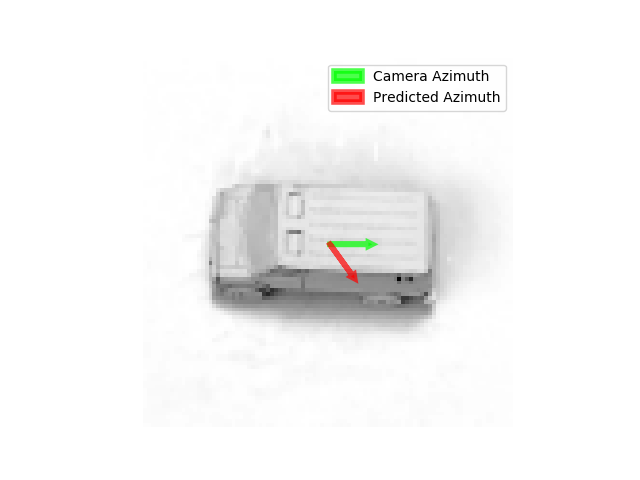

<IPython.core.display.Javascript object>


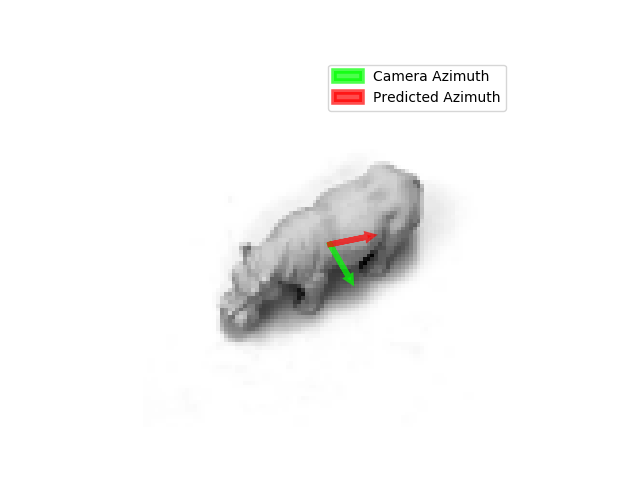

<IPython.core.display.Javascript object>


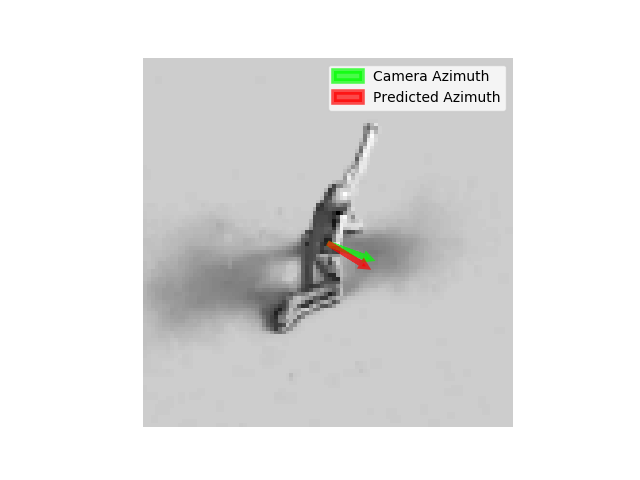

<IPython.core.display.Javascript object>


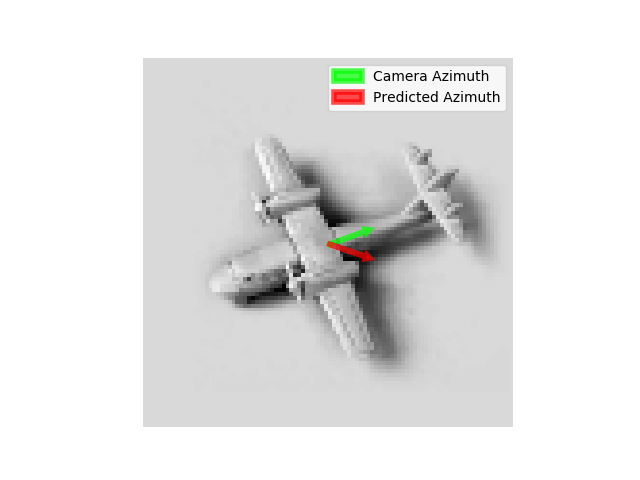

<IPython.core.display.Javascript object>


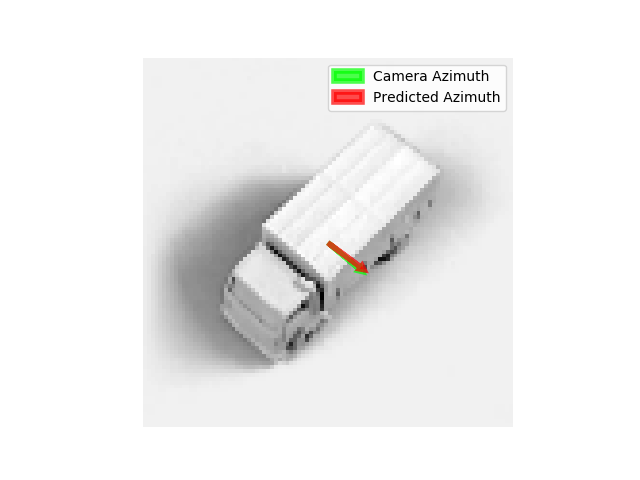

<IPython.core.display.Javascript object>


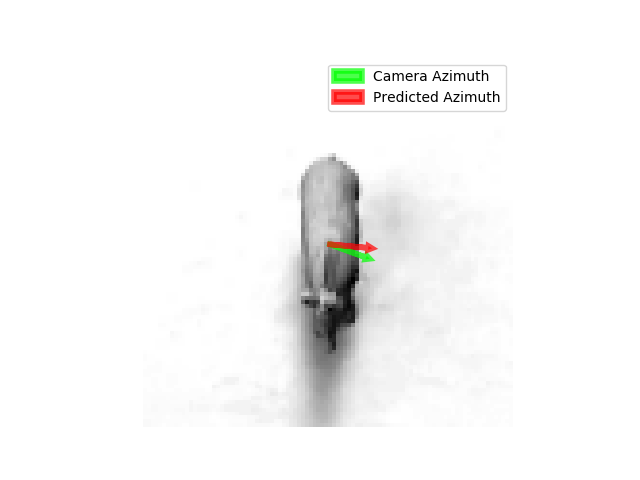

<IPython.core.display.Javascript object>


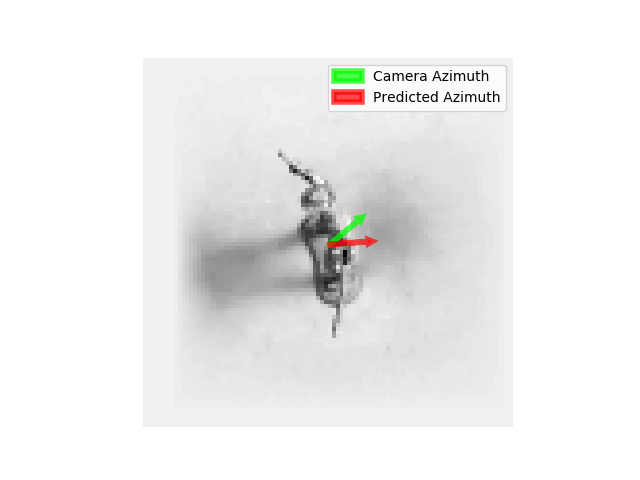

<IPython.core.display.Javascript object>


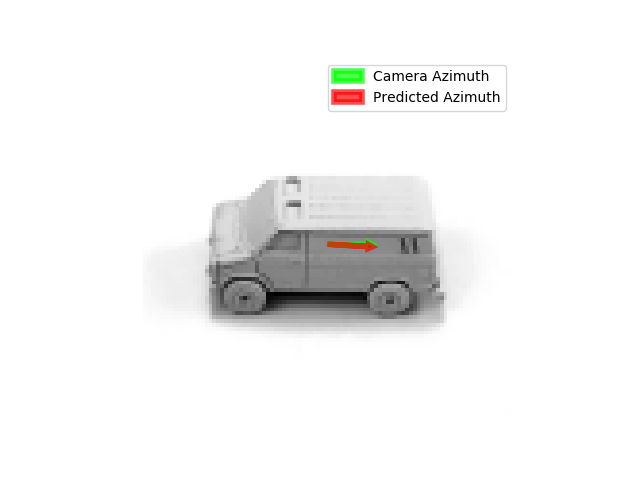

<IPython.core.display.Javascript object>


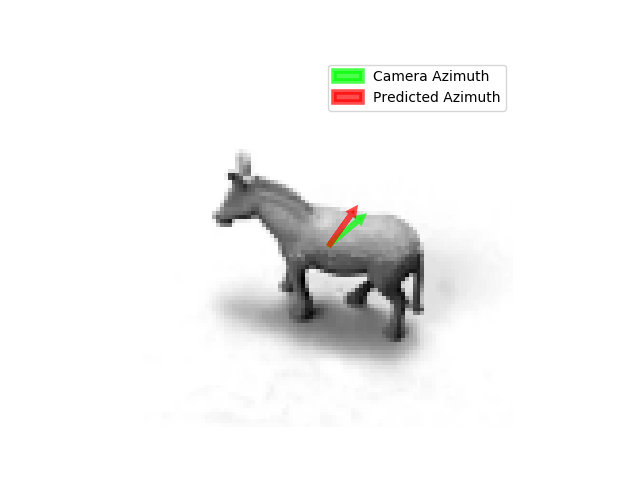

<IPython.core.display.Javascript object>


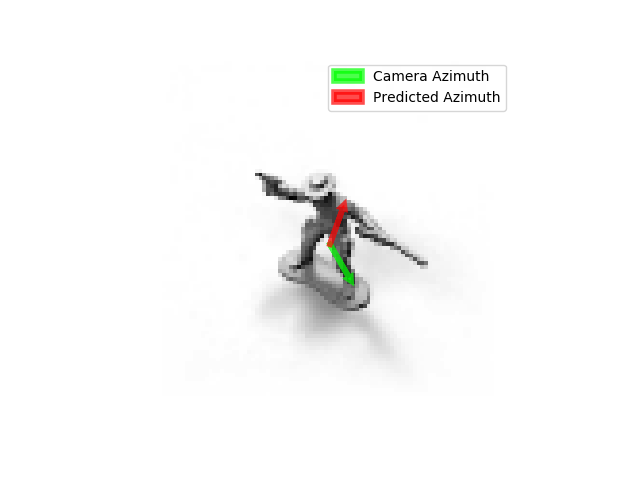

<IPython.core.display.Javascript object>


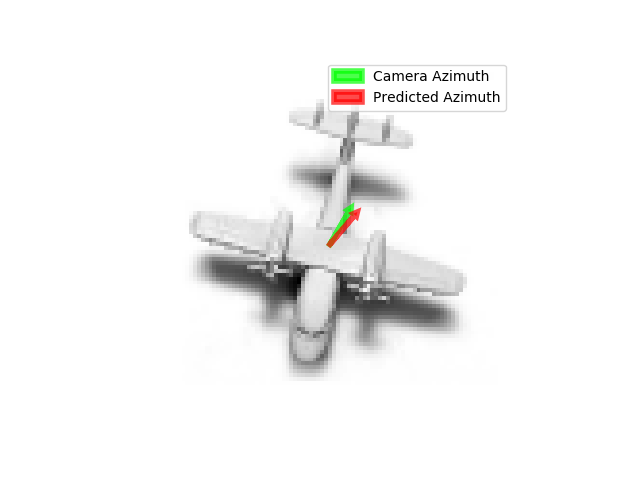

<IPython.core.display.Javascript object>


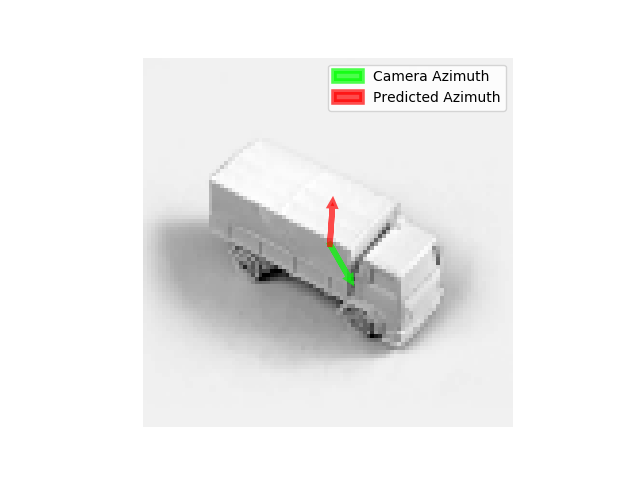

<IPython.core.display.Javascript object>


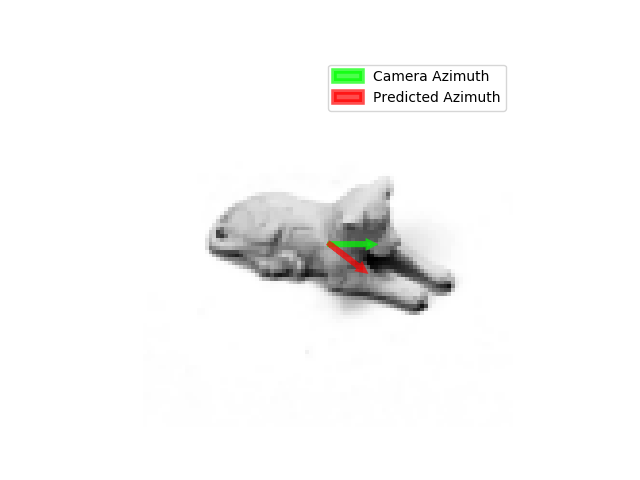

<IPython.core.display.Javascript object>


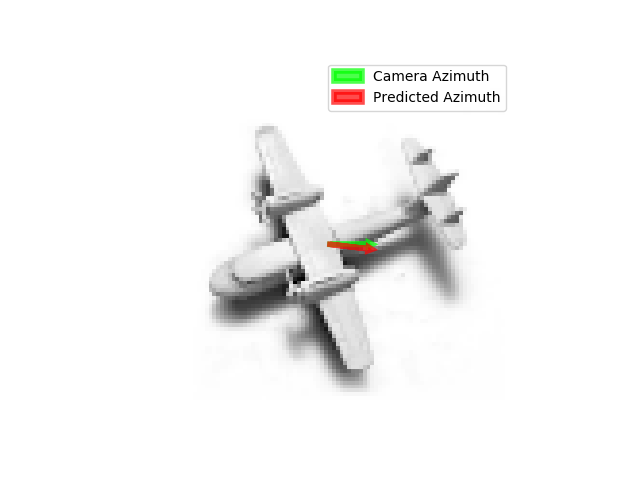

<IPython.core.display.Javascript object>


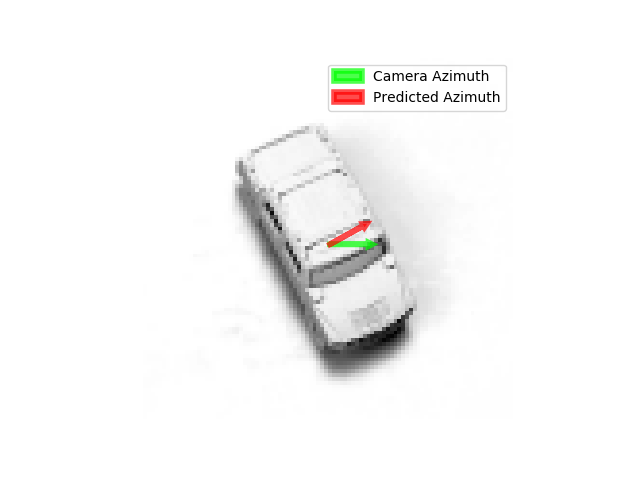

<IPython.core.display.Javascript object>


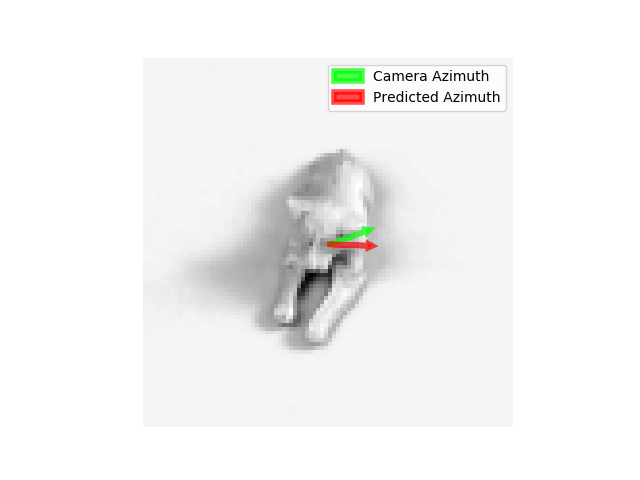

<IPython.core.display.Javascript object>


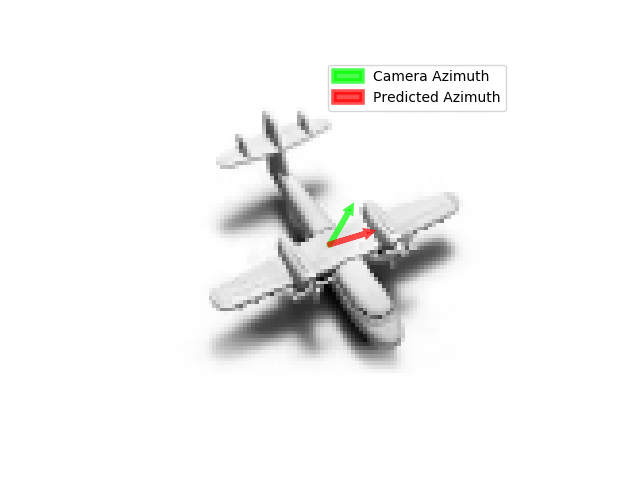

<IPython.core.display.Javascript object>


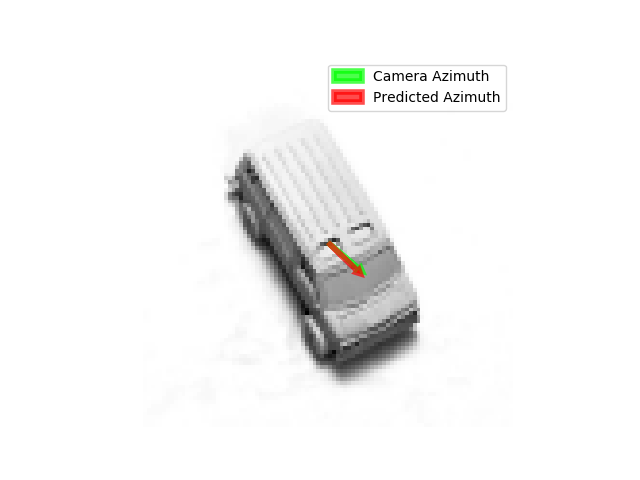

<IPython.core.display.Javascript object>


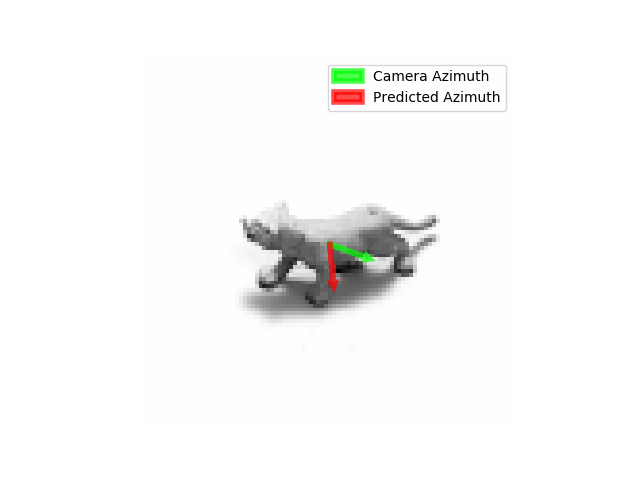

<IPython.core.display.Javascript object>


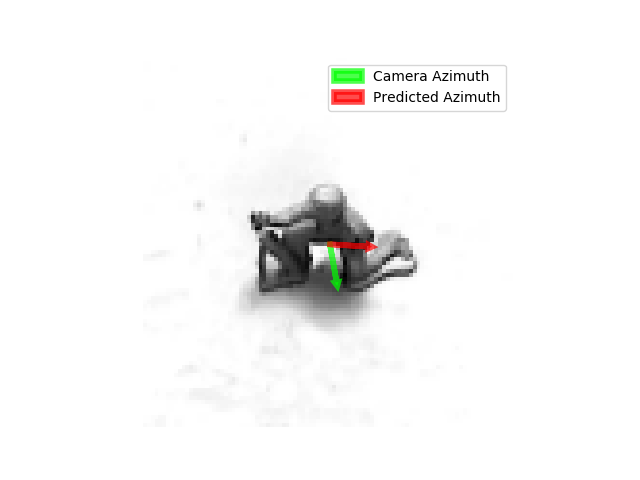

<IPython.core.display.Javascript object>


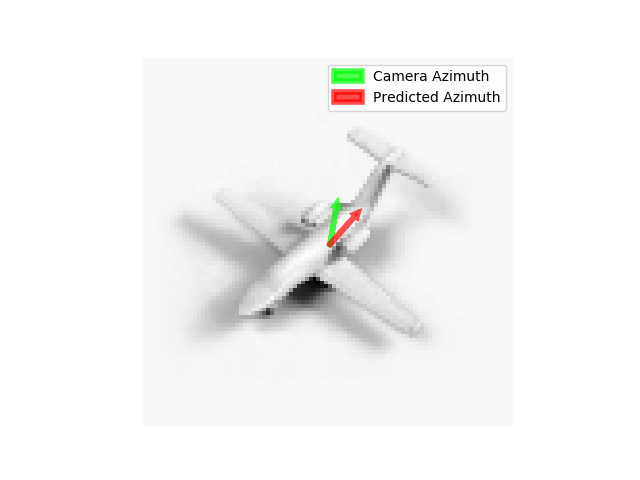

<IPython.core.display.Javascript object>


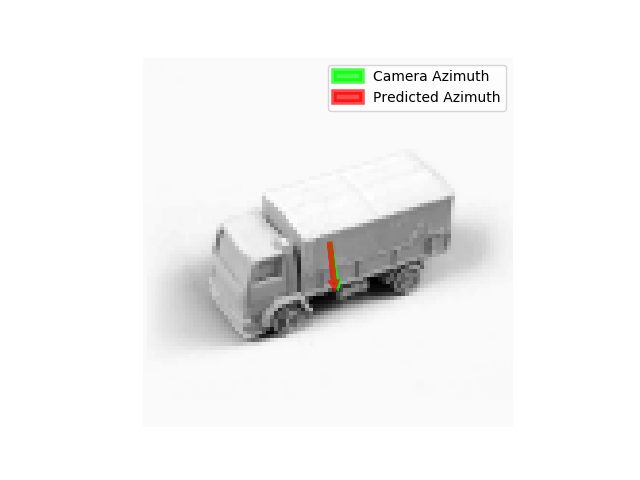

<IPython.core.display.Javascript object>


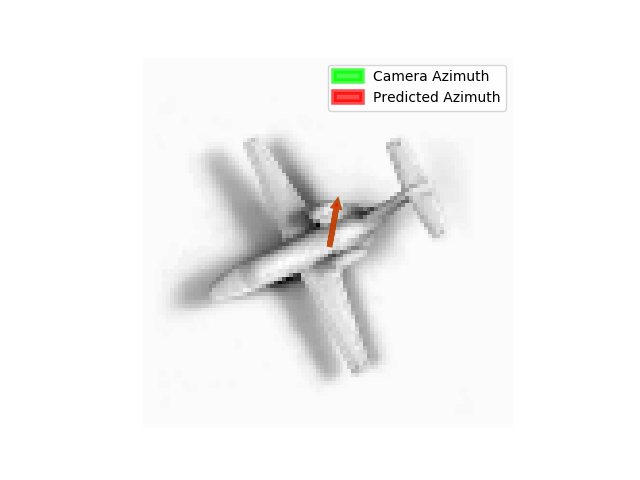

<IPython.core.display.Javascript object>


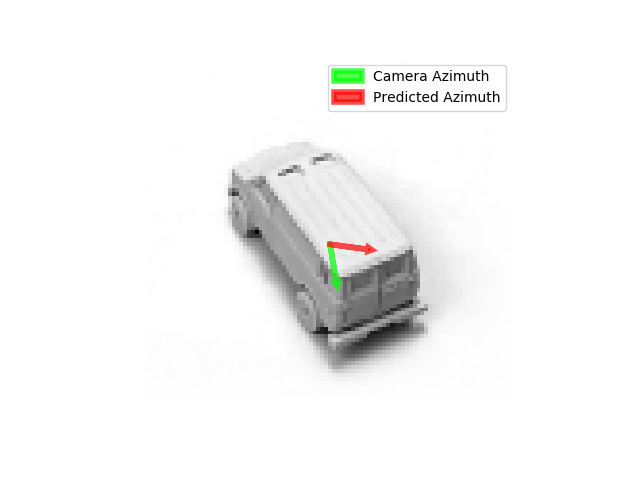

<IPython.core.display.Javascript object>


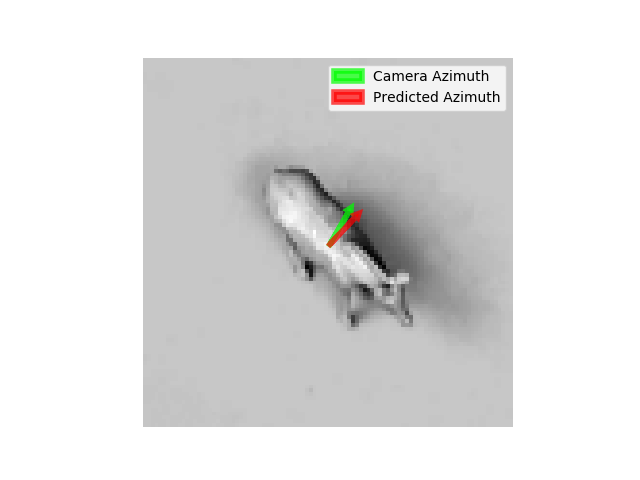

<IPython.core.display.Javascript object>


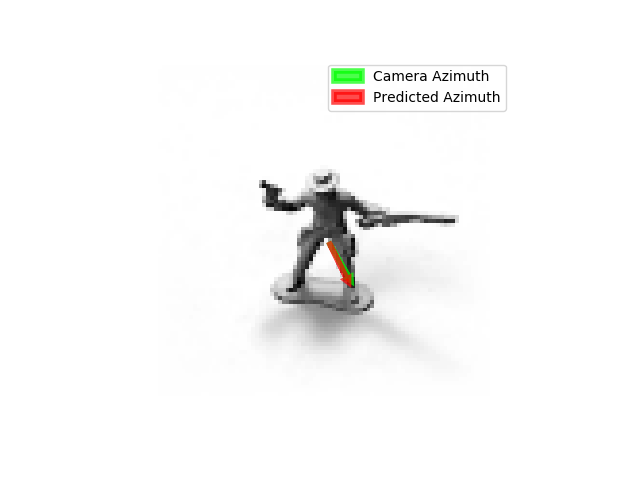

<IPython.core.display.Javascript object>


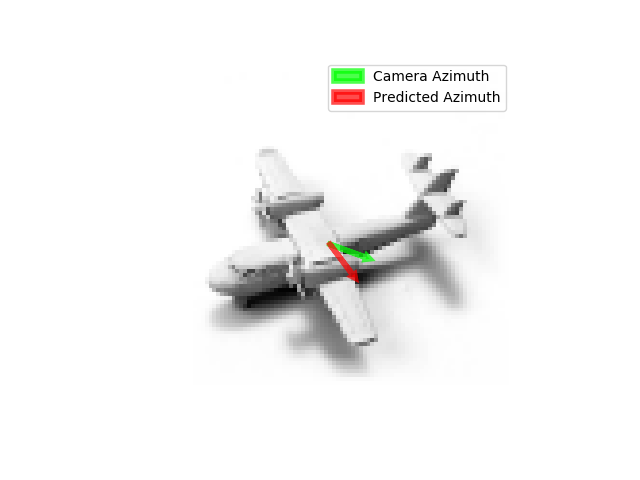

<IPython.core.display.Javascript object>


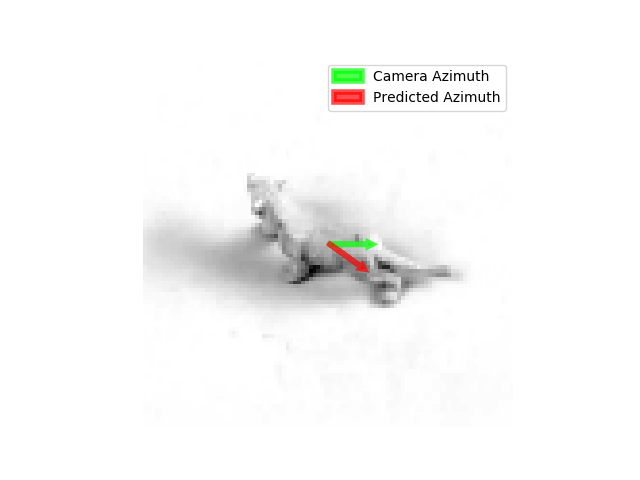

<IPython.core.display.Javascript object>


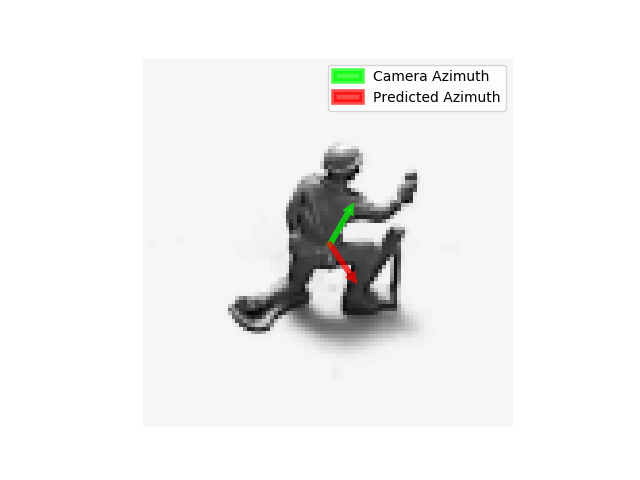

<IPython.core.display.Javascript object>


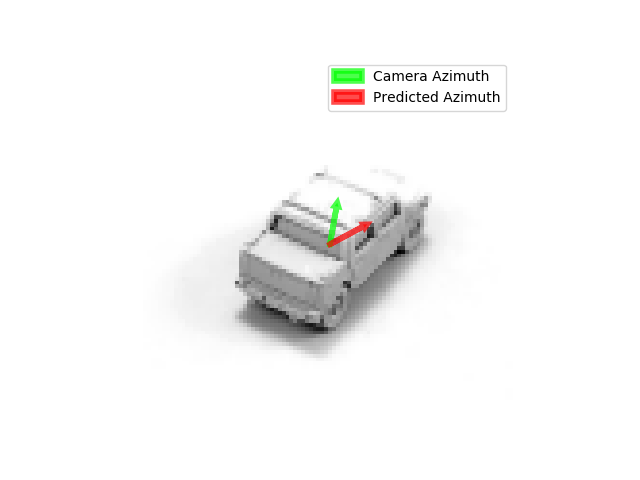

<IPython.core.display.Javascript object>


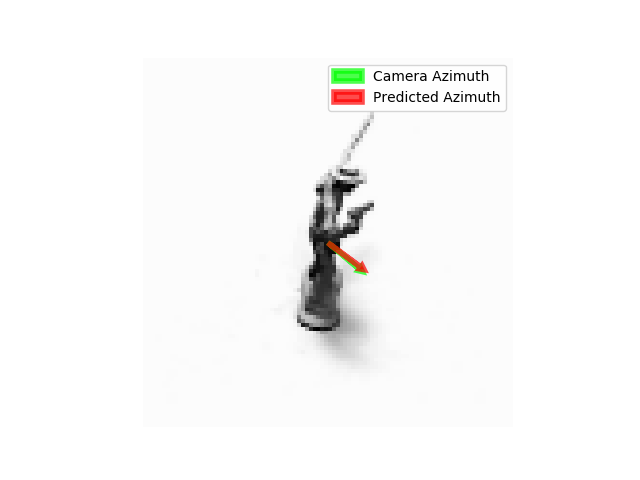

<IPython.core.display.Javascript object>


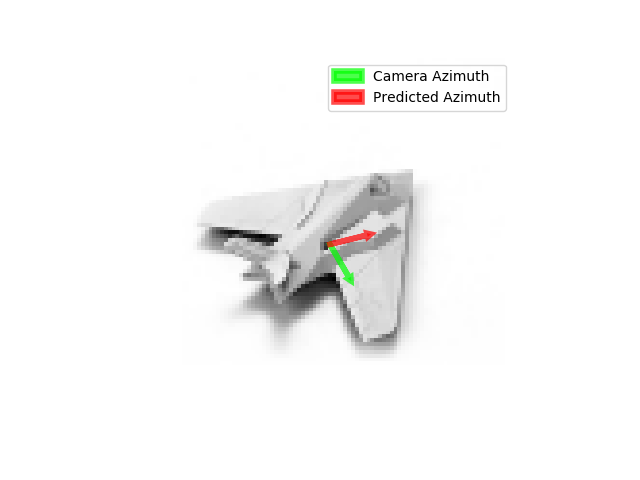

<IPython.core.display.Javascript object>


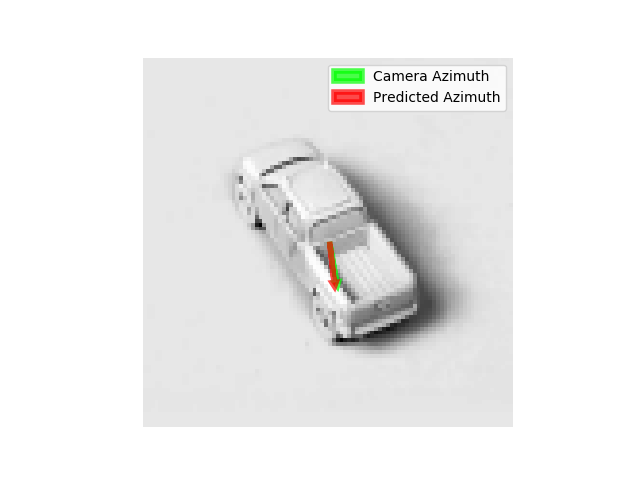

In [204]:
batch = 2
mu, U = get_pose(img_data[batch_size * batch: batch_size * (batch + 1)].cuda())
pose_example = pose[batch_size * batch: batch_size * (batch + 1)].float().cuda()
U = U[:, 0, :] * torch.Tensor([1, -1]).view(1, 2).cuda()
    
for example_index in range(50):
    x_diff, y_diff = pose_example[example_index]
    current_orientation = U[example_index] 
    
    fig, ax = plt.subplots()
    
    ax.imshow(img_data[example_index, 0], cmap='gray')
    arrow_scale = 10
    
    arrow1 = ax.arrow(48, 48, x_diff * arrow_scale, y_diff * arrow_scale,
                    head_width=1, head_length=1, fc=(0, 1, 0), ec=(0, 1, 0), linewidth=4, alpha=0.7, label='Label')

    arrow2 = ax.arrow(48, 48, current_orientation[0].data * arrow_scale, current_orientation[1].data * arrow_scale,
                    head_width=1, head_length=1, fc='red', ec='red', linewidth=4, alpha=0.7, label='Prediction')
    ax.legend([arrow1, arrow2], ['Camera Azimuth', 'Predicted Azimuth'])
    ax.axis('off')
    plt.savefig('./SmallNorbResults/fig_{}'.format(example_index + batch*batch_size))

In [9]:
train_imgs = img_data[:12000].float()
train_labels = pose[:12000].float()

test_imgs = img_data[12000:].float()
test_labels = pose[12000:].float()

print(train_imgs.shape)
train = torch.utils.data.TensorDataset(train_imgs, train_labels.view(-1, 2))
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False, num_workers=0)

test = torch.utils.data.TensorDataset(test_imgs, test_labels.view(-1, 2))
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False, num_workers=0)

torch.Size([12000, 1, 96, 96])


In [10]:
class CNNBasic(torch.nn.Module):
    def __init__(self):
        super(CNNBasic, self).__init__()
        self.features1 = torch.nn.Sequential(
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(1, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(16, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), ######
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(32, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), ######
        )
        self.features2 = torch.nn.Sequential(
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(32, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(32, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), ######
        )

        self.regressor1 = torch.nn.Sequential(
            torch.nn.Dropout(p=0.25),
            torch.nn.ReLU(),
            torch.nn.Linear(12*12*32, 30),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(30, 2)
        )
        
        # self.pose_norm = PoseNormalization(32, img_shape=(24, 24))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)

        x = x.view(x.size(0), -1)

        x = self.regressor1(x)
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNNBasic().to(device)
criterion_cnn = torch.nn.MSELoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.005)

batch_num = 50
epoch_num = 25
cnn, cnn_loss, cnn_acc, cnn_loss_validation = utils.train_net(cnn, train_loader, 
              test_loader, criterion_cnn, optimizer_cnn, batch_num, epoch_num, validation_split=0.1)

TOTAL TRAIN 1600
TOTAL VALIDATION 1200
TOTAL TEST 1608
STOPPING EPOCH
Loss: 0.14859450550749898, Acc: 0.0, Validation Loss: 0.011011963995794455
STOPPING EPOCH
Loss: 0.01003690492361784, Acc: 0.0, Validation Loss: 0.00882357057183981
STOPPING EPOCH
Loss: 0.009608183754608035, Acc: 0.0, Validation Loss: 0.00809187871714433
STOPPING EPOCH
Loss: 0.008697158247232438, Acc: 0.0, Validation Loss: 0.007931140959262848
STOPPING EPOCH
Loss: 0.008310885736718773, Acc: 0.0, Validation Loss: 0.007574749067425728
STOPPING EPOCH
Loss: 0.007643290394917131, Acc: 0.0, Validation Loss: 0.020224864160021148
STOPPING EPOCH
Loss: 0.00732630574144423, Acc: 0.0, Validation Loss: 0.006796506755053997
STOPPING EPOCH
Loss: 0.006548249870538711, Acc: 0.0, Validation Loss: 0.006498698778450489
STOPPING EPOCH
Loss: 0.005954960794188082, Acc: 0.0, Validation Loss: 0.006363012672712405
STOPPING EPOCH
Loss: 0.00566507407464087, Acc: 0.0, Validation Loss: 0.00520169798284769
STOPPING EPOCH
Loss: 0.005283614173531532,

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


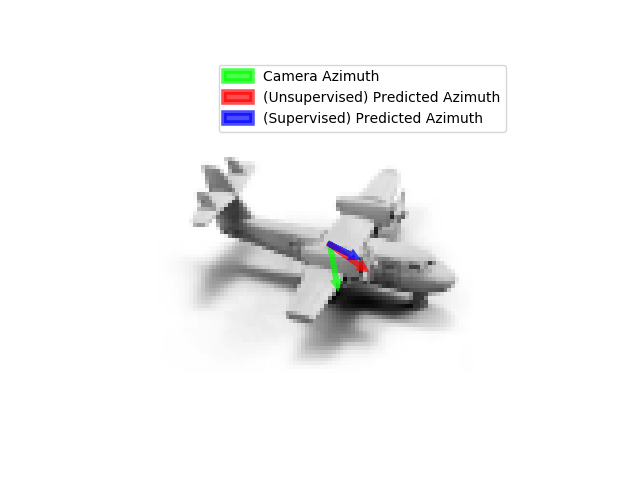

<IPython.core.display.Javascript object>


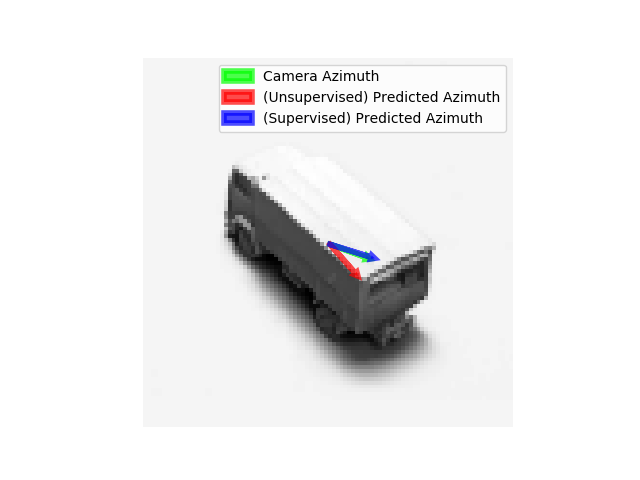

<IPython.core.display.Javascript object>


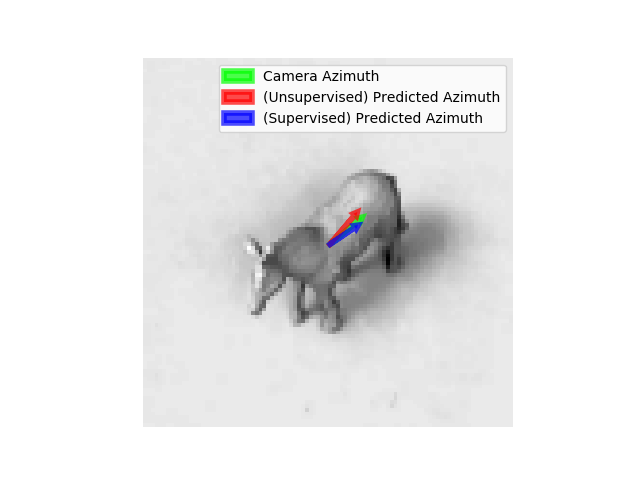

<IPython.core.display.Javascript object>


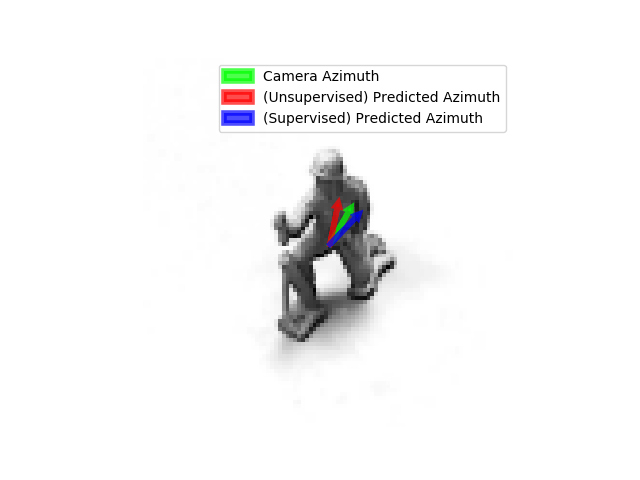

<IPython.core.display.Javascript object>


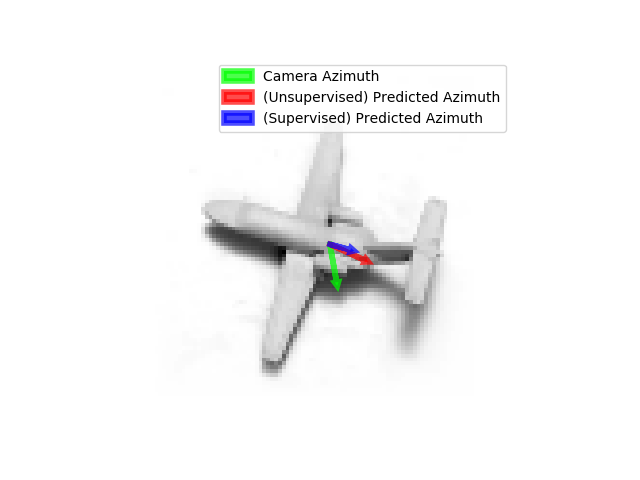

<IPython.core.display.Javascript object>


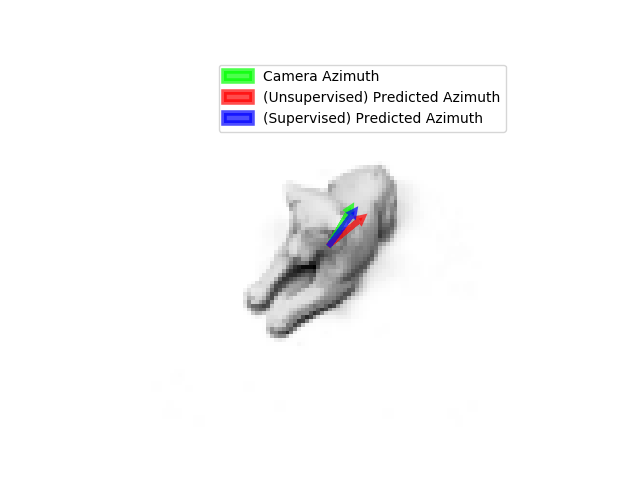

<IPython.core.display.Javascript object>


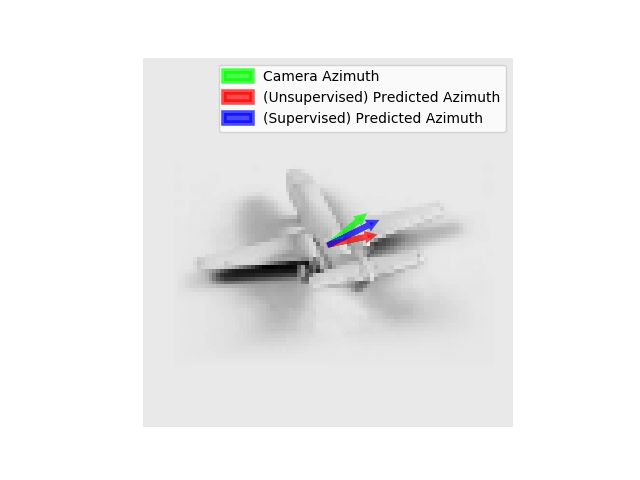

<IPython.core.display.Javascript object>


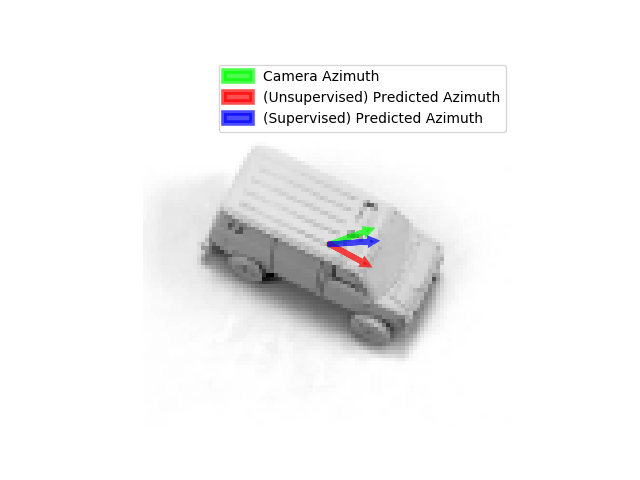

<IPython.core.display.Javascript object>


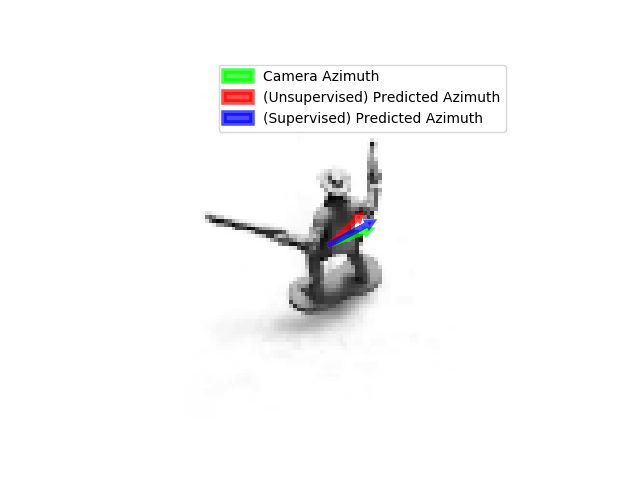

<IPython.core.display.Javascript object>


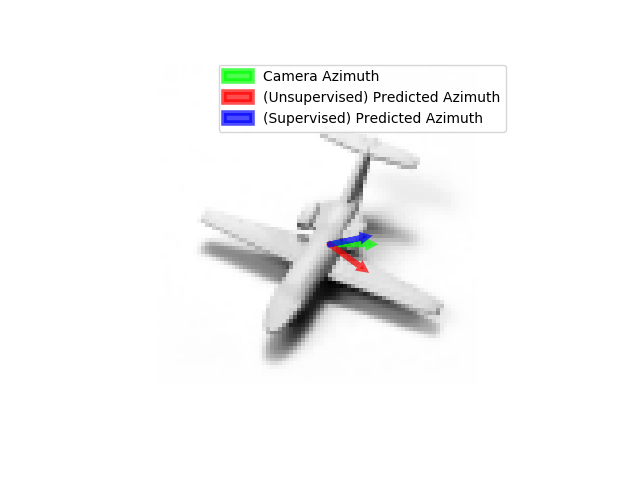

<IPython.core.display.Javascript object>


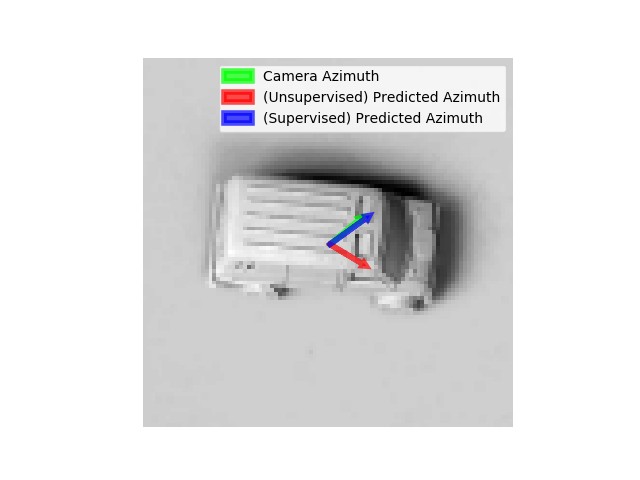

<IPython.core.display.Javascript object>


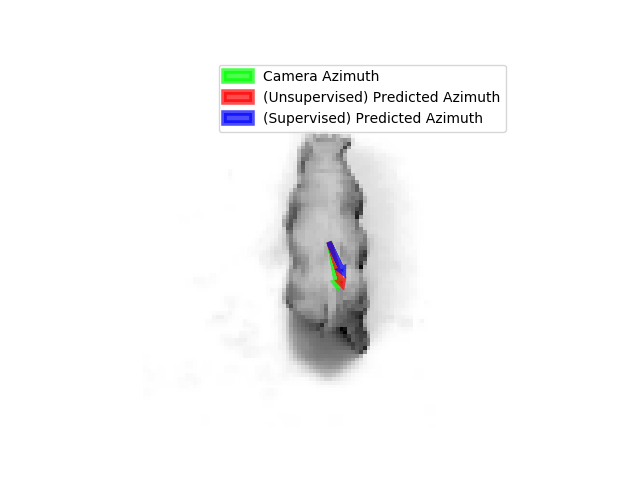

<IPython.core.display.Javascript object>


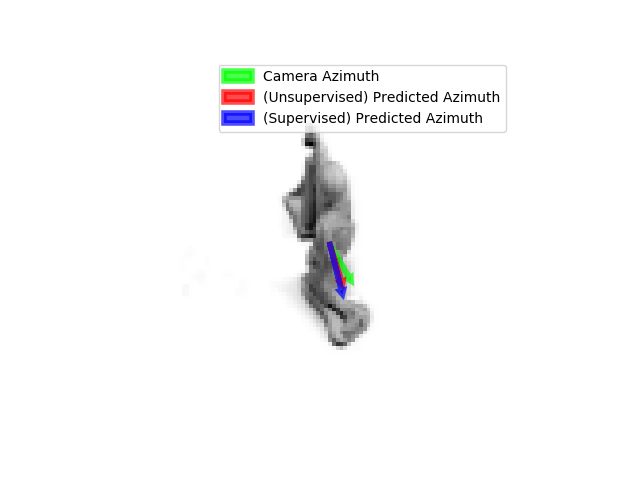

<IPython.core.display.Javascript object>


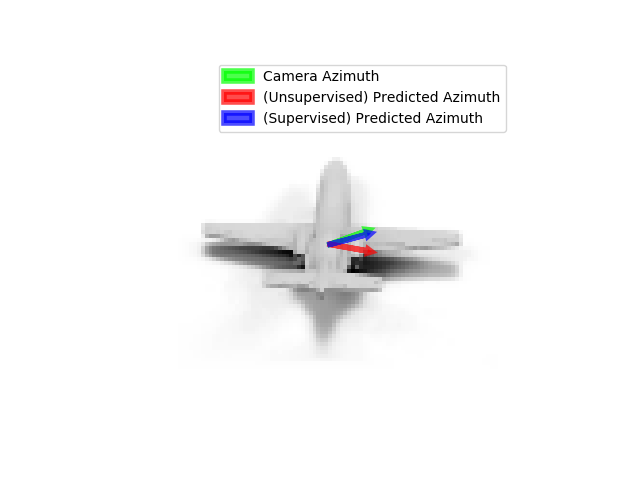

<IPython.core.display.Javascript object>


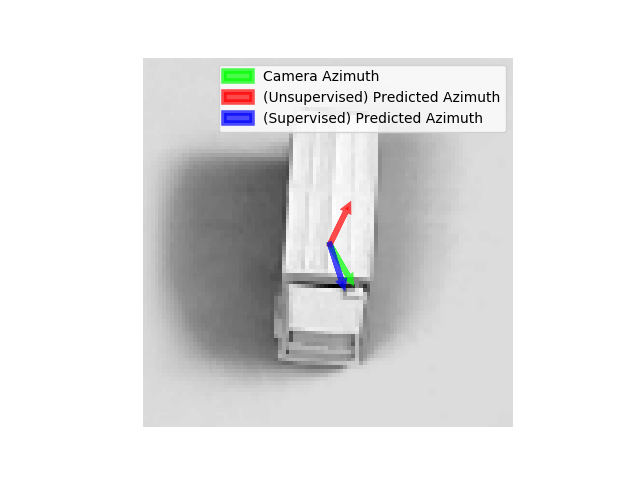

In [12]:
batch = 250
batch_size = 50
mu, U = get_pose(img_data[batch_size * batch: batch_size * (batch + 1)].cuda())
pose_example = pose[batch_size * batch: batch_size * (batch + 1)].float().cuda()
U = U[:, 0, :] * torch.Tensor([1, -1]).view(1, 2).cuda()
cnn_predict = cnn(img_data[batch_size * batch: batch_size * (batch + 1)].cuda())


for example_index in range(15):
    x_diff, y_diff = pose_example[example_index]
    cnn_orientation = cnn_predict[example_index]
    current_orientation = U[example_index] 
    
    fig, ax = plt.subplots()
    
    ax.imshow(img_data[(batch_size * batch) + example_index, 0], cmap='gray')
    arrow_scale = 10
    
    arrow1 = ax.arrow(48, 48, x_diff * arrow_scale, y_diff * arrow_scale,
                    head_width=1, head_length=1, fc=(0, 1, 0), ec=(0, 1, 0), linewidth=4, alpha=0.7, label='Label')

    arrow2 = ax.arrow(48, 48, current_orientation[0].data * arrow_scale, current_orientation[1].data * arrow_scale,
                    head_width=1, head_length=1, fc='red', ec='red', linewidth=4, alpha=0.7, label='Prediction')
    
    arrow3 = ax.arrow(48, 48, cnn_orientation[0].data * arrow_scale, cnn_orientation[1].data * arrow_scale,
                head_width=1, head_length=1, fc='blue', ec='blue', linewidth=4, alpha=0.7, label='Prediction')
    ax.legend([arrow1, arrow2, arrow3], ['Camera Azimuth', '(Unsupervised) Predicted Azimuth', '(Supervised) Predicted Azimuth'])
    ax.axis('off')
#     plt.savefig('./SmallNorbResults/fig_{}'.format(example_index + batch*batch_size))

In [29]:
batch * batch_size

5000

In [36]:
loss_function = torch.nn.MSELoss()
batch_size = 50
loss_value_pinn = 0
loss_value_cnn = 0

total_batches = 0
for (img, pose) in train_loader:
    total_batches += 1
    pose = pose.cuda()
    mu, U = get_pose(img.cuda())
    cnn_prediction = cnn(img.cuda())

    U = U[:, 0, :] * torch.Tensor([1, -1]).view(1, 2).cuda()
    rand_pose = torch.zeros_like(pose_example)
#     rand_pose = torch.nn.functional.normalize(rand_pose, dim = 1)
    loss_pinn = torch.mean(torch.norm(pose - U, dim = 1))
    loss_cnn = torch.mean(torch.norm(pose - cnn_prediction, dim = 1))

    loss_value_pinn += loss_pinn.item()
    loss_value_cnn += loss_cnn.item()
    
final_pinn_loss = loss_value_pinn / total_batches
final_cnn_loss = loss_value_cnn / total_batches

print("PINN Loss", final_pinn_loss)
print("CNN Loss", final_cnn_loss)

PINN Loss 0.6013715478579204
CNN Loss 0.44587215630213417
